
# Data Preparation and Exploration

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import requests
import json
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
import pandas as pd
sb.set() # set the default Seaborn style for graphics

---
## Data Preparation
**AIM:**
1) Decide on suitable predictor variables for our response variables ("profit", " revenue" and " rating")

2) Remove any outliers or identify any anomalies that might affect our model or predictor/response variables, and correct them.

In [2]:
preparingData = pd.read_csv("cleanData.csv")
preparingData = preparingData.drop(["Unnamed: 0"], axis=1)
preparingData.dtypes

budget               float64
original_language     object
popularity           float64
release_date          object
revenue              float64
runtime              float64
title                 object
vote_average         float64
vote_count           float64
Metascore              int64
imdbRating           float64
Genre                 object
Year                   int64
Ratings               object
Rated                 object
dtype: object

****
---
## RESPONSE VARIABLE I: MOVIE RATINGS
Metrics available for our use: 
'imdbRating', 'popularity', 'Metascore', 'vote_average', 'vote_count'

We have a couple of different movie rating variables that can be utilized. Before deciding on which ones to use, we will first observe the relationship between each different movie rating variables using the heatmap plotted below.

<AxesSubplot:>

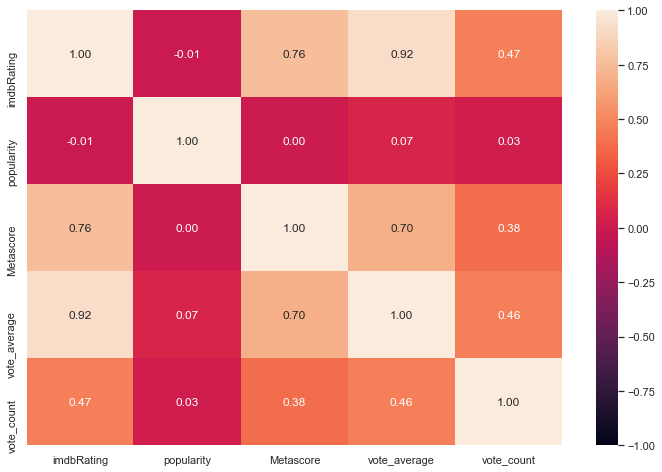

In [3]:
ratinglist = ['imdbRating','popularity', 'Metascore', 'vote_average', 'vote_count'] #list of various rating variables
ratinglistframe = [pd.DataFrame(preparingData[x]) for x in ratinglist]
ratings_relationship = pd.concat(ratinglistframe, axis=1). reindex(ratinglistframe[0].index)

f = plt.figure(figsize=(12, 8))
sb.heatmap(ratings_relationship.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f") #plotting heatmap of correlation between rating variables

By comparing correlation values, "popularity" and "vote_count" do not have a very linear correlation with the other rating variables. 
This would mean that they are not accurate representations of our movie ratings, hence we should exclude them. 

After elminating these two variables, we still need to decide on what should be our response variable for ratings. We still have "imbdRating", "Metascore", and "Vote average" to choose, all which enjoy a strong relationship with each other.

IDEA: We decided that in order to improve reliability and accuracy of our chosen perfomance metric, we will create a rating that takes into account the average of "imbdRating", "Metascore", and "Vote average".

In [4]:
preparingData["Metascore"] /= 10.00 # Metascore is the only variable which has the max score of 100, compared to the imbdRating and vote average of 10.

general_rating = preparingData["Metascore"]/ 3.00 + preparingData["imdbRating"]/ 3.00 + preparingData["vote_average"]/ 3.00 #average the total sum of scores

preparingData["general_rating"] = general_rating

preparingData.drop(ratinglist,inplace=True, axis=1)  #No longer need the other rating variables now that we have created a generalized rating 

Let's take a look at how many movies were released for each year.

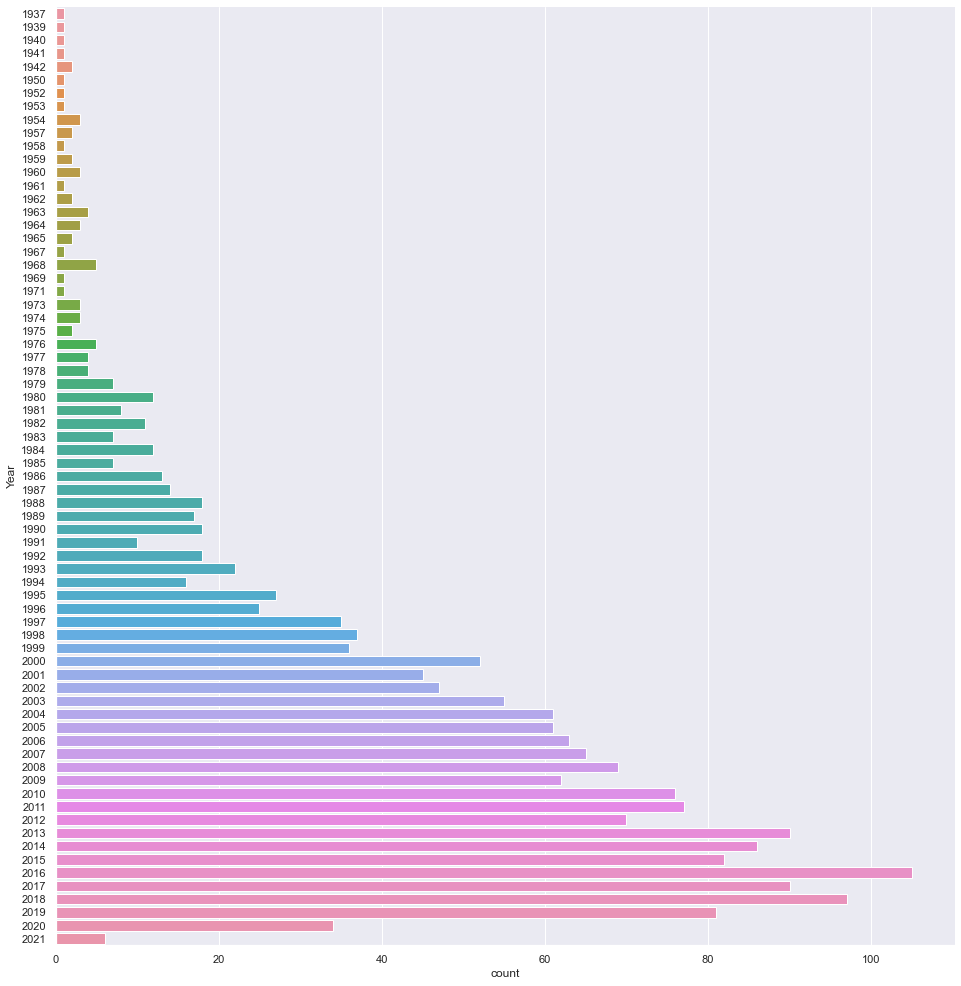

In [5]:
# Movies in each year
g = sb.catplot(y = "Year", data = preparingData, kind = "count")
g.fig.set_size_inches(15,15)

Note that , the number of movies that were released in the more recent years, eg. 1970s to 2000s, are way higher then movies released in the earlier years, eg. 1940s to 1960s. 
This will be an issue when we try to predict performance of movies based on the year. If only one movie in our dataset was released in 1937, depending on the movie rating, this would skew our linear regression line. An example of this is shown below. 

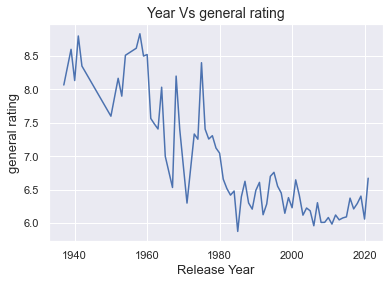

In [6]:
preparingData.groupby('Year')['general_rating'].mean().plot()

#setup the title and labels of the figure.
plt.title("Year Vs general rating",fontsize = 14)
plt.xlabel('Release Year',fontsize = 13)
plt.ylabel('general rating',fontsize = 13)

#setup the figure size.
sb.set(rc={'figure.figsize':(10,8)})
sb.set_style("whitegrid")

Note how the trend seems to be decreasing. Does this look correct?

In [7]:
print("Number of movies released in year of 1937: ",preparingData[preparingData.Year==1937].shape[0])
print("Number of movies released in year of 2017: ",preparingData[preparingData.Year==2017].shape[0])
print(preparingData[preparingData.Year==1937].title , '  General rating:', preparingData[preparingData.Year==1937].general_rating)

Number of movies released in year of 1937:  1
Number of movies released in year of 2017:  90
249    Snow White and the Seven Dwarfs
Name: title, dtype: object   General rating: 249    8.066667
Name: general_rating, dtype: float64


For example, you can see that only ONE movie, snow white and the seven dwarfs was released in 1937. The average movie rating for 1937 was 8.06. 

This skews our graph of release year vs mean average general rating by a relatively bad amount. This could
be extended to revenue or profits too. Thus, we need to ensure that the amount of movies released in a particular year should be
a reasonable size, if we want to determine if year of release is a suitable response variable for our performance metrics.


How do we do this? By **Narrowing the set of movies that we will analyse based on their sample size*. We will take movies from more recent years, 2000-2018, which has a larger sample size as compared to movies from 1937 to 1999, as seen from the cat plot above.**

In [8]:
#Removing outlier years
for x in range(1937,1999):
    preparingData = preparingData[preparingData.Year!=x]
    
#Removing outlier ratings which might be caused by small sample size
preparingData = preparingData[((preparingData.general_rating - preparingData.general_rating.mean()) / preparingData.general_rating.std()).abs() < 3] #Removing outlier values

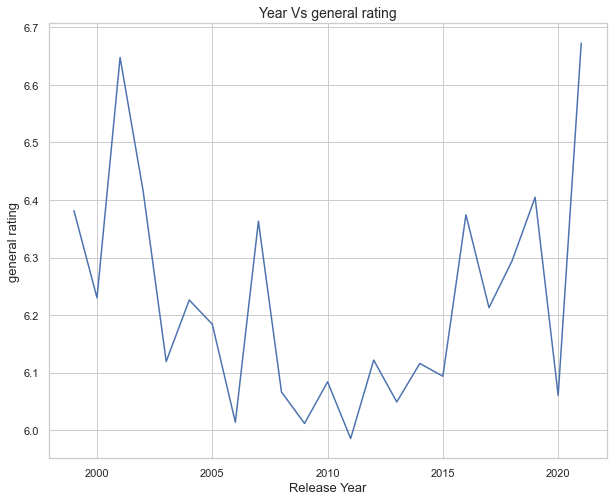

In [9]:
preparingData.groupby('Year')['general_rating'].mean().plot()

#setup the title and labels of the figure.
plt.title("Year Vs general rating",fontsize = 14)
plt.xlabel('Release Year',fontsize = 13)
plt.ylabel('general rating',fontsize = 13)

#setup the figure size.
sb.set(rc={'figure.figsize':(10,8)})
sb.set_style("whitegrid")

Note how the trend looks less skewed now. The above graph would be a more accurate representation of average movie ratings vs the year, thanks to the larger sample size of each year.



****
---
## RESPONSE VARIABLE II: Profits / Revenue

In [10]:
preparingData.describe()

,budget,revenue,runtime,Year,general_rating
count,1.506000e+03,1.506000e+03,1506.000000,1506.000000,1506.000000
mean,5.810090e+07,1.936312e+08,111.327357,2010.675299,6.197233
std,5.615081e+07,2.712763e+08,18.696556,5.962353,1.060068
min,1.000000e+01,1.000000e+00,70.000000,1999.000000,3.133333
25%,1.980000e+07,4.293061e+07,98.000000,2006.000000,5.466667
50%,4.000000e+07,1.002034e+08,108.000000,2011.000000,6.133333
75%,8.000000e+07,2.150168e+08,122.000000,2016.000000,6.966667
max,3.800000e+08,2.797801e+09,201.000000,2021.000000,8.933333


As we can see, for budget and revenue, the minimum revenue and data is 10 and 1 respectively. This is a fault of the TMBD data set, instead of putting 1 million, the value is 1. Thus we should filter these values. We take the minimum value for revenue and profits to be 1 000 000.

In [11]:
preparingData = preparingData[preparingData["revenue"]>1000000]
preparingData = preparingData[preparingData["budget"]>1000000]

In [12]:
preparingData.describe()

,budget,revenue,runtime,Year,general_rating
count,1.451000e+03,1.451000e+03,1451.000000,1451.000000,1451.000000
mean,5.999069e+07,2.002289e+08,111.697450,2010.587870,6.206524
std,5.631593e+07,2.740425e+08,18.697191,5.960071,1.054411
min,1.100000e+06,1.023510e+06,72.000000,1999.000000,3.133333
25%,2.000000e+07,4.665840e+07,98.000000,2006.000000,5.466667
50%,4.000000e+07,1.043842e+08,109.000000,2011.000000,6.133333
75%,8.000000e+07,2.192605e+08,122.000000,2016.000000,6.983333
max,3.800000e+08,2.797801e+09,201.000000,2021.000000,8.933333


Firstly, let's take a look at how the profit of movies have changed over the years. Profit = Revenue - Budget

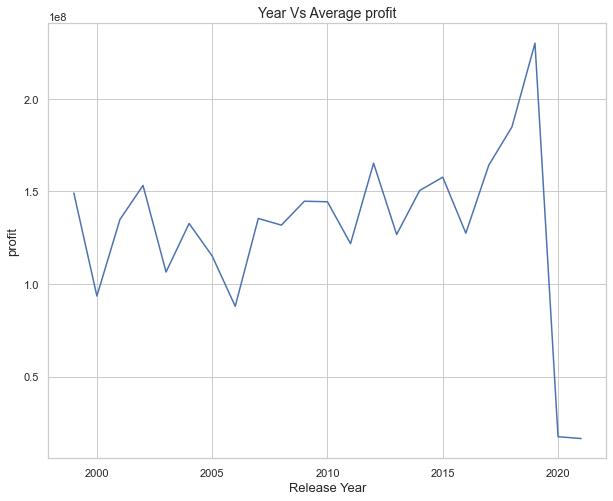

In [13]:
profit = preparingData["revenue"] - preparingData["budget"]
preparingData["profit"] = profit

preparingData.groupby('Year')['profit'].mean().plot()

#setup the title and labels of the figure.
plt.title("Year Vs Average profit",fontsize = 14)
plt.xlabel('Release Year',fontsize = 13)
plt.ylabel('profit',fontsize = 13)

#setup the figure size.
sb.set(rc={'figure.figsize':(10,8)})
sb.set_style("whitegrid")

It is clear that as the years go by, average profit for a movie has increased due to **inflation**. **Real growth** is thus **not represented accurately**, as the monetary values have not been adjusted for inflation. As such we decided to adjust profits, revenue and budget based on the CPI index of that year in which the movie was released, which is given by the equation:

**adjusted_profit = (old_profit * cpi_current) / cpi_old**


Note: It is important that we take into account inflation when calculating profits. By adjusting for inflation, we uncover the real growth, if any. we may also stabilize the variance of random or seasonal fluctuations and/or highlight cyclical patterns in the movie dataset.


In [14]:
import cpi #cpi library contains all the CPI indedes for each year.
cpi.update() #updating cpi library to get relevant year cpi indexes. Error will still pop out

#cpi module does not include CPI indexes for 2019 - 2020. Thus we shall only analyze movies up to 2018.
for x in range(2019,2022):
 preparingData = preparingData[preparingData.Year!=x]  

def inflate_column(data, column):
    """
    Adjust for inflation the series of values in column of the   
    dataframe data
    """
    return data.apply(lambda x: cpi.inflate(x[column], 
                      x.Year), axis=1)

preparingData["real_budget"] = inflate_column(preparingData, "budget")
preparingData["real_revenue"] =  inflate_column(preparingData, "revenue") #revenue adjusted for inflation
real_profit = preparingData["real_revenue"] - preparingData["real_budget"] #budget adjusted for inflation
preparingData["real_profit"] = real_profit

#Removing outlier values
preparingData = preparingData[((preparingData.real_profit - preparingData.real_profit.mean()) / preparingData.real_profit.std()).abs() < 3]

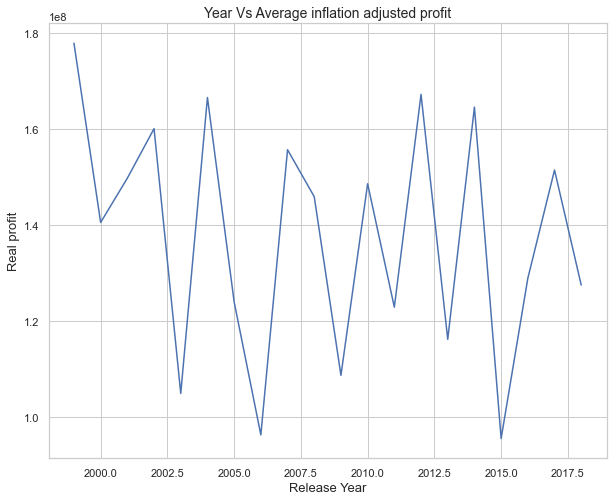

In [15]:
preparingData.groupby('Year')['real_profit'].mean().plot()

#setup the title and labels of the figure.
plt.title("Year Vs Average inflation adjusted profit",fontsize = 14)
plt.xlabel('Release Year',fontsize = 13)
plt.ylabel('Real profit',fontsize = 13)

#setup the figure size.
sb.set(rc={'figure.figsize':(10,8)})
sb.set_style("whitegrid")

The Graph above shows a more accurate representation of year VS profit, adjusted for inflation.

In [16]:
preparingData.to_csv('prepped_ready2exploreData.csv')

---
## Data  Exploration

In [17]:
#preparingData.to_csv('prepped_ready2exploreData.csv')
exploringData = pd.read_csv('prepped_ready2exploreData.csv')
exploringData.drop(["Unnamed: 0"],inplace=True, axis=1)
exploringData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   budget             1302 non-null   float64
 1   original_language  1302 non-null   object 
 2   release_date       1302 non-null   object 
 3   revenue            1302 non-null   float64
 4   runtime            1302 non-null   float64
 5   title              1302 non-null   object 
 6   Genre              1302 non-null   object 
 7   Year               1302 non-null   int64  
 8   Ratings            1302 non-null   object 
 9   Rated              1302 non-null   object 
 10  general_rating     1302 non-null   float64
 11  profit             1302 non-null   float64
 12  real_budget        1302 non-null   float64
 13  real_revenue       1302 non-null   float64
 14  real_profit        1302 non-null   float64
dtypes: float64(8), int64(1), object(6)
memory usage: 152.7+ KB


Now that we have prepared our response variables, we should explore our predictor variables and the **relationship between
the predictor and the response variables**.

Our response variables can be seperated into numerical and caterogical data.

**1) Numerical: real_budget, runtime**

**2) Caterogical: original language, release date/ year, genre and ratings (pg13, R21), etc.**

## 1) Numerical predictor variables

In [18]:
numericlist = ['runtime', 'real_budget', 'general_rating', "real_revenue", 'real_profit']
numericData = pd.concat([pd.DataFrame(exploringData[x]) for x in numericlist], axis=1).reindex(exploringData['runtime'].index)
numericData.describe()

,runtime,real_budget,general_rating,real_revenue,real_profit
count,1302.000000,1.302000e+03,1302.000000,1.302000e+03,1.302000e+03
mean,110.874808,6.814041e+07,6.163210,2.043191e+08,1.361787e+08
std,17.978521,6.145161e+07,1.053232,2.232521e+08,1.835159e+08
min,72.000000,1.265641e+06,3.133333,1.149410e+06,-1.841009e+08
25%,98.000000,2.373803e+07,5.433333,5.702562e+07,1.950864e+07
50%,108.000000,4.734471e+07,6.100000,1.272909e+08,7.532805e+07
75%,121.000000,9.588417e+07,6.933333,2.557143e+08,1.722590e+08
max,188.000000,4.372216e+08,8.900000,1.218609e+09,9.422432e+08


                 runtime  real_budget  general_rating  real_revenue  \
runtime         1.000000     0.305079        0.425850      0.250438   
real_budget     0.305079     1.000000        0.056955      0.726707   
general_rating  0.425850     0.056955        1.000000      0.242264   
real_revenue    0.250438     0.726707        0.242264      1.000000   
real_profit     0.202506     0.549202        0.275649      0.973184   

                real_profit  
runtime            0.202506  
real_budget        0.549202  
general_rating     0.275649  
real_revenue       0.973184  
real_profit        1.000000  


<AxesSubplot:>

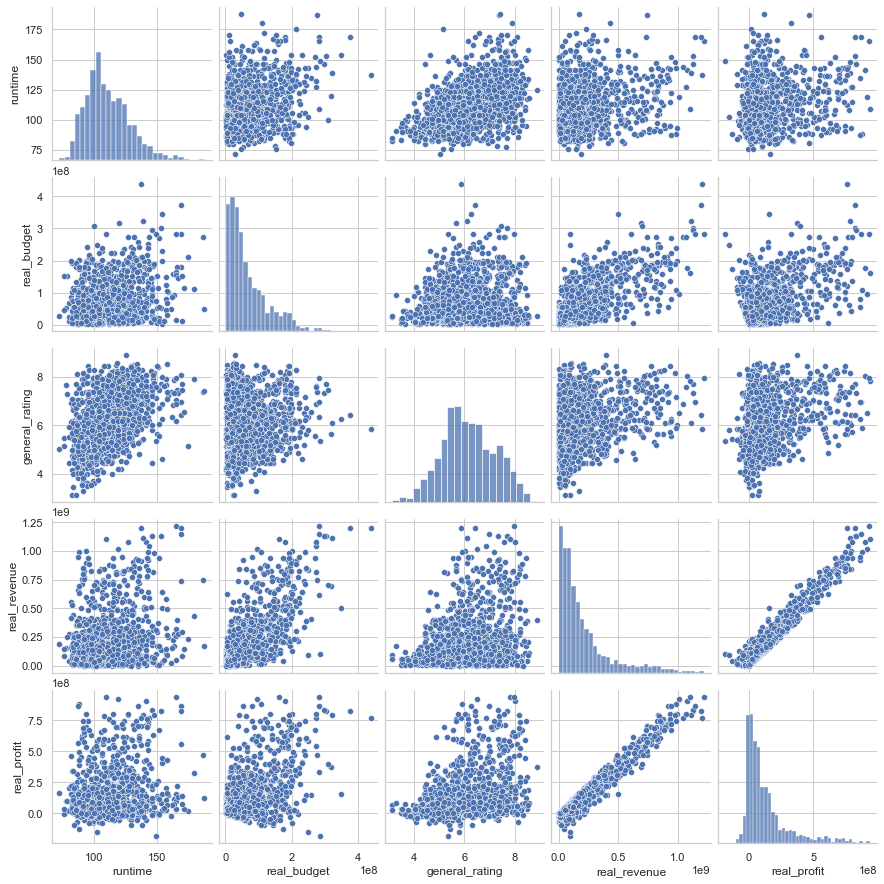

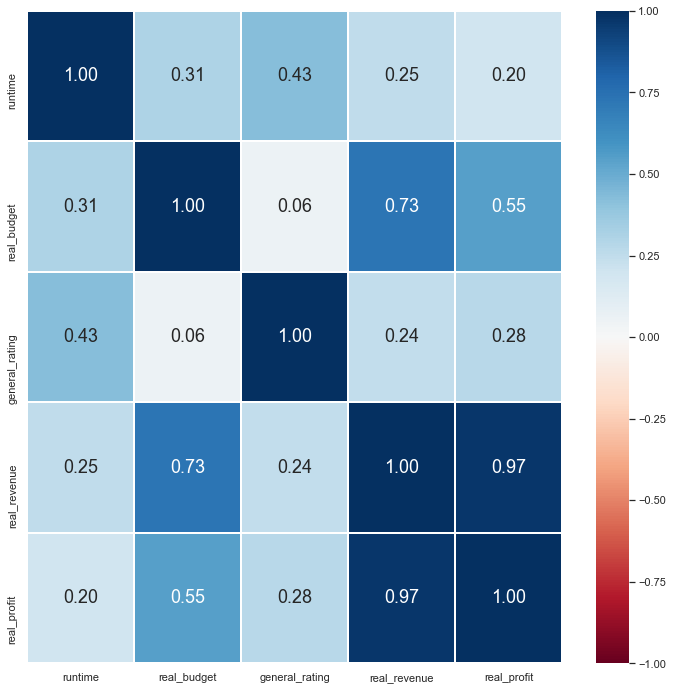

In [19]:
sb.pairplot(data = numericData)

# Correlation Matrix
print(numericData.corr())

# Heatmap of the Correlation Matrix
f = plt.figure(figsize=(12, 12))
sb.heatmap(numericData.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

We define a function to explore the relationship between our predictor variable and our 3 response variables, Adjusted revenue, 
adjusted profits and general rating.

In [20]:
def explore_linear_rs(predictor, response):
    plt.scatter(x = exploringData[predictor], y = exploringData[response])
    plt.title(str(predictor) + "vs" + str(response))
    plt.xlabel(str(predictor))
    plt.ylabel(str(response))
    
    df= pd.concat([exploringData[predictor], exploringData[response]], axis=1)
    print(df.corr())
    
    x = exploringData[predictor]
    y = exploringData[response]
    m, b = np.polyfit(x, y, 1)
    plt.plot(x,m*x+b, color = "red")
    
    
    

---
## i) BUDGET

**BUDGET VS REAL REVENUE**

              real_budget  real_revenue
real_budget      1.000000      0.726707
real_revenue     0.726707      1.000000


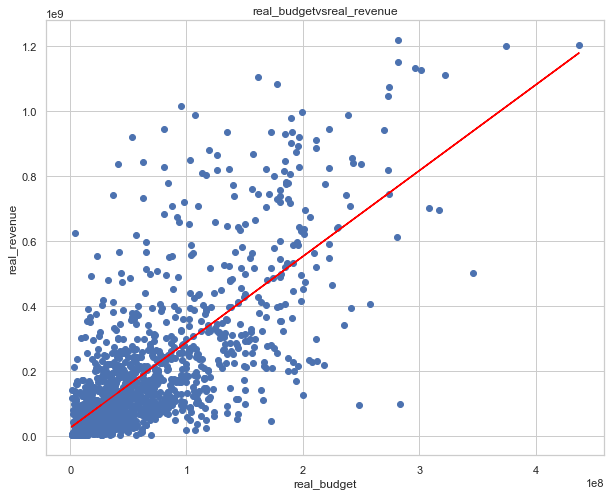

In [21]:
explore_linear_rs("real_budget", "real_revenue")

**Comments on adjusted Budget v adjusted revenue**

The correlation value and scatter plot above indicates that there is a STRONG positive correlation between budget and real revenue. 

The best-fit line below shows that an increase in Budget will lead to an increase in revenue. Since we are able to derive a relative relationship between budget and profit, we can conclude that Budget could be a strong indicator in predicting the real revenue of the movie.

**BUDGET VS REAL PROFIT**

             real_budget  real_profit
real_budget     1.000000     0.549202
real_profit     0.549202     1.000000


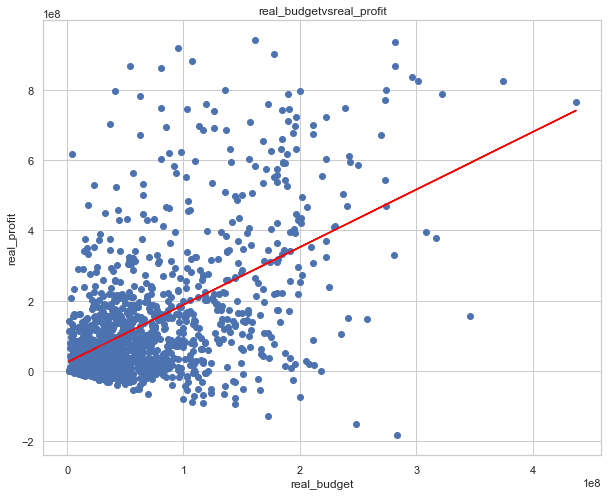

In [22]:
explore_linear_rs("real_budget", "real_profit")

**Comments on Budget v Real Profits**

The correlation value and scatter plot above indicates that there is a moderate positive correlation between budget and real profits. 

The best-fit line below shows that an increase in Budget will lead to an increase in Profit. Since we are able to derive a relative relationship between budget and profit, we can conclude that Budget could be a indicator in predicting the real profits of the movie.

**BUDGET VS RATING**

                real_budget  general_rating
real_budget        1.000000        0.056955
general_rating     0.056955        1.000000


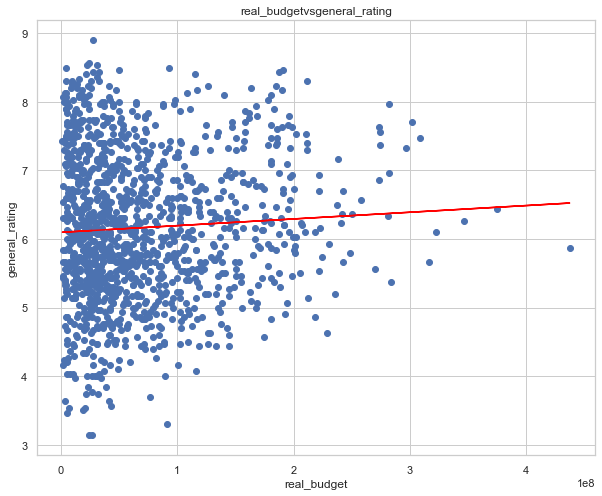

In [23]:
explore_linear_rs("real_budget", "general_rating")

**Comments on Budget v General Ratings**

As seen from the correlation value and the scatter plot above, we can tell that there is a very weak positive correlation between budget and general ratings.

Since there is almost no relationship between budget and general ratings, Budget will **not** be a good indicator in helping us predict the General Ratings of a movie. 

---
## ii) RUN-TIME

 **RUN-TIME VS REAL REVENUE**

               runtime  real_revenue
runtime       1.000000      0.250438
real_revenue  0.250438      1.000000


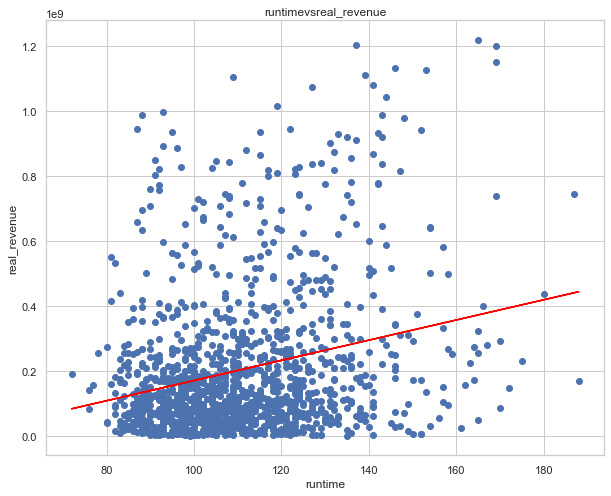

In [24]:
explore_linear_rs("runtime", "real_revenue")

**Comments on Runtime v Adjusted Revenue**

Considering the correlation value as well as the how the points are distributed on the scatterplot, we can tell that there is a poor correlation between runtime and adjusted revenue. 
Hence, we can conclude that runtime would not be a good indicator in predicting real profits of the movie.

**RUNTIME VS PROFIT**

              runtime  real_profit
runtime      1.000000     0.202506
real_profit  0.202506     1.000000


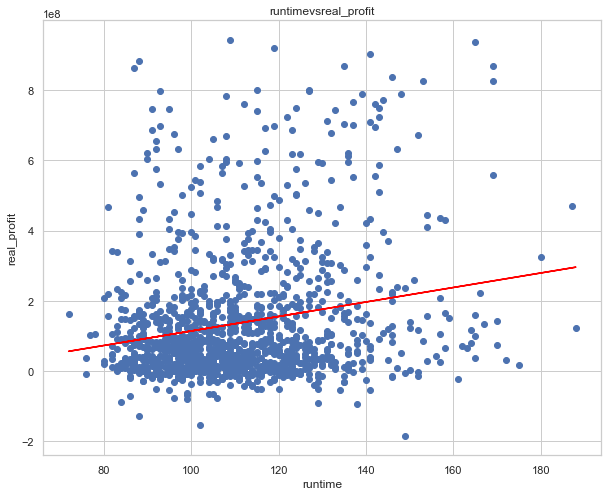

In [25]:
explore_linear_rs("runtime", "real_profit")

**Comments on Runtime v Real Profits**

Considering the correlation value as well as the how the points are distributed on the scatterplot, we can tell that there is a poor correlation between runtime and real profits. 
Hence, we can conclude that runtime would not be a good indicator in predicting real profits of the movie.

**RUNTIME VS RATING**

                runtime  general_rating
runtime         1.00000         0.42585
general_rating  0.42585         1.00000


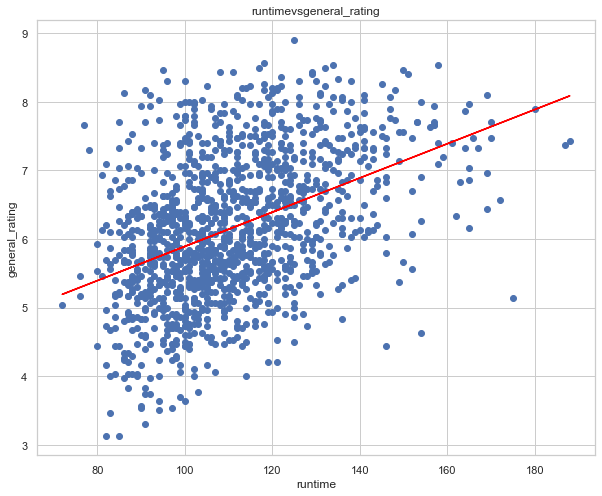

In [26]:
explore_linear_rs("runtime", "general_rating")

**Comments on Runtime v General Rating**

The correlation value and scatter plot above indicates that there is a moderate positive correlation between runtime and general ratings. 

The best-fit line plotted shows that an increase in Runtime will lead to an increase in Profit. Since we are able to derive a relative relationship between runtime and general ratings, we can conclude that Runtime could be a indicator in predicting the general ratings of the movie.

## 2) Caterogical predictor variables

---
## i) Release Year 

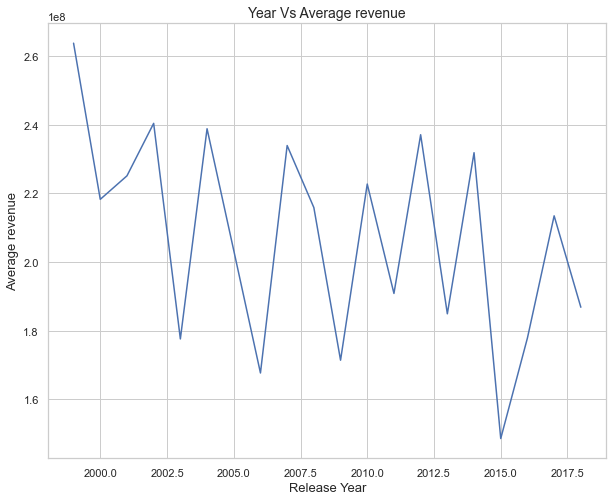

In [27]:
exploringData.groupby('Year')['real_revenue'].mean().plot()

#setup the title and labels of the figure.
plt.title("Year Vs Average revenue",fontsize = 14)
plt.xlabel('Release Year',fontsize = 13)
plt.ylabel('Average revenue',fontsize = 13)

#setup the figure size.
sb.set(rc={'figure.figsize':(10,8)})
sb.set_style("whitegrid")

<AxesSubplot:xlabel='real_revenue', ylabel='Year'>

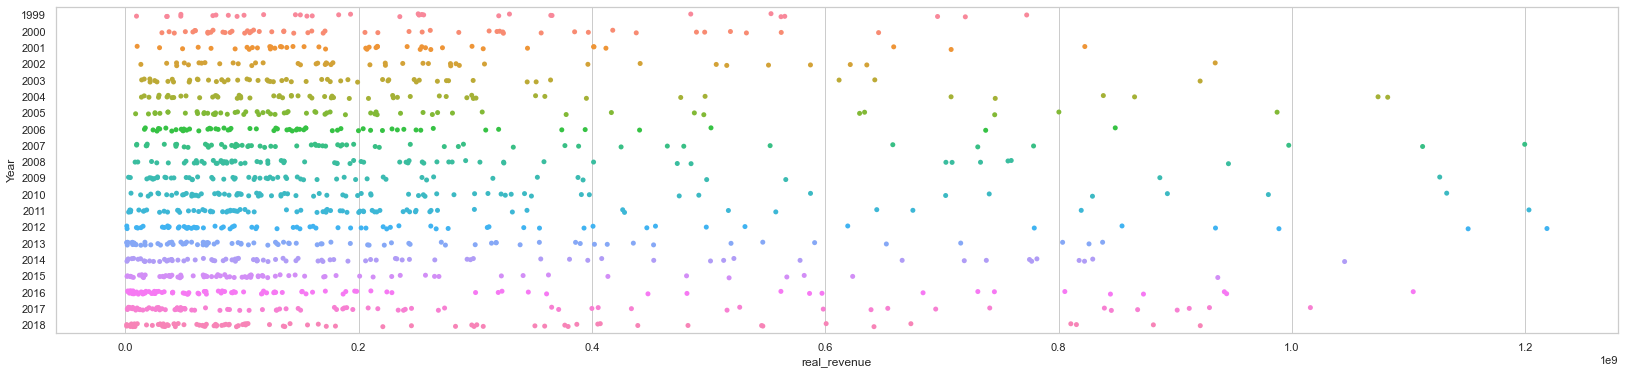

In [28]:
f = plt.figure(figsize=(28, 6))
sb.stripplot(x ="real_revenue", y = "Year", data = exploringData, orient = "h")

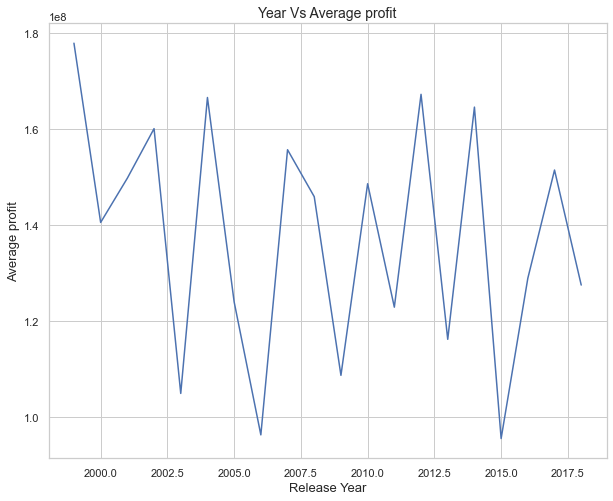

In [29]:
exploringData.groupby('Year')['real_profit'].mean().plot()

#setup the title and labels of the figure.
plt.title("Year Vs Average profit",fontsize = 14)
plt.xlabel('Release Year',fontsize = 13)
plt.ylabel('Average profit',fontsize = 13)

#setup the figure size.
sb.set(rc={'figure.figsize':(10,8)})
sb.set_style("whitegrid")

<AxesSubplot:xlabel='real_profit', ylabel='Year'>

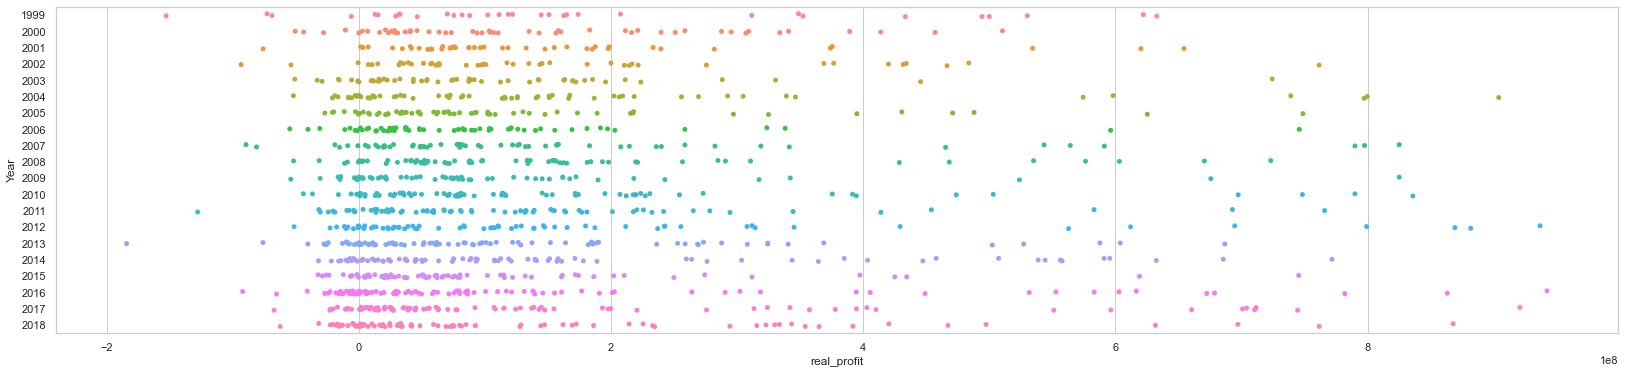

In [30]:
f = plt.figure(figsize=(28, 6))
sb.stripplot(x ="real_profit", y = "Year", data = exploringData, orient = "h")

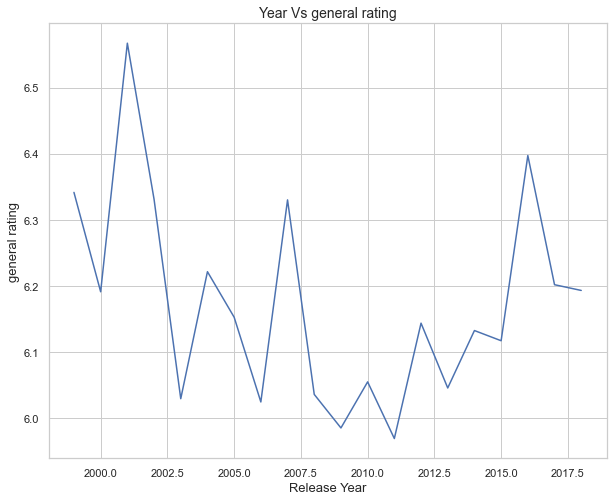

In [31]:
exploringData.groupby('Year')['general_rating'].mean().plot()

#setup the title and labels of the figure.
plt.title("Year Vs general rating",fontsize = 14)
plt.xlabel('Release Year',fontsize = 13)
plt.ylabel('general rating',fontsize = 13)

#setup the figure size.
sb.set(rc={'figure.figsize':(10,8)})
sb.set_style("whitegrid")

<AxesSubplot:xlabel='general_rating', ylabel='Year'>

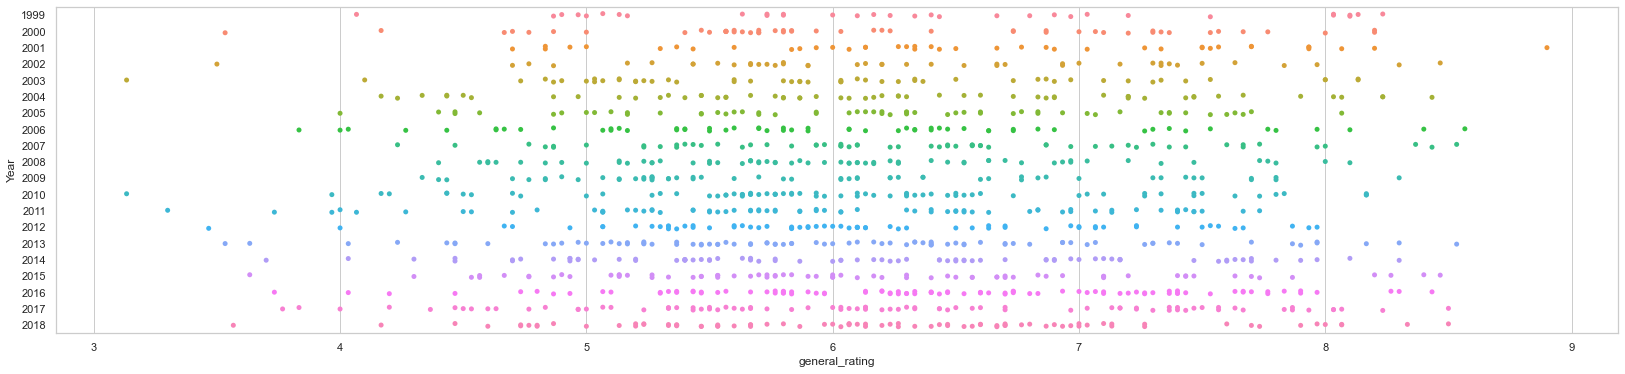

In [32]:
f = plt.figure(figsize=(28, 6))
sb.stripplot(x ="general_rating", y = "Year", data = exploringData, orient = "h")

**Comments on Year as a performance indicator for movies**

As we can see from the scatter plot, there isn't much correlation between year and ratings / profits / revenue. Can we say the same about month of release? Perhaps people prefer to watch the movies at certain months of the year, for example, festive seasons.

---
## ii) Release Month

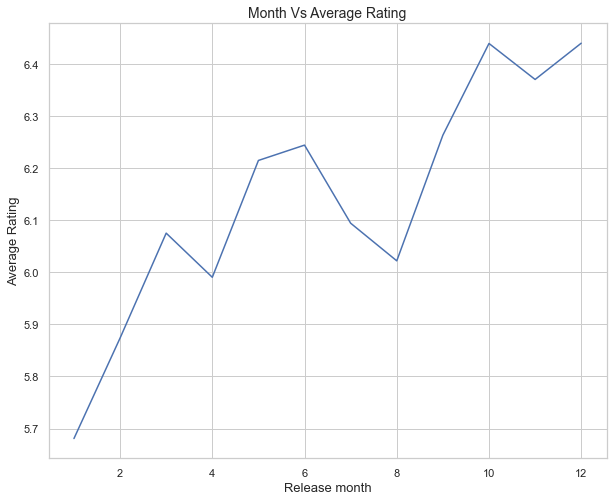

In [33]:
monthlist=[]
for i in range(len(exploringData["release_date"])):
    string= exploringData["release_date"][i]
    month =int(string[5:7])
    monthlist.append(month)
    
exploringData["month of release"] = pd.DataFrame(monthlist)


exploringData.groupby('month of release')['general_rating'].mean().plot()

#setup the title and labels of the figure.
plt.title("Month Vs Average Rating",fontsize = 14)
plt.xlabel('Release month',fontsize = 13)
plt.ylabel('Average Rating',fontsize = 13)

#setup the figure size.
sb.set(rc={'figure.figsize':(10,8)})
sb.set_style("whitegrid")

<AxesSubplot:xlabel='general_rating', ylabel='month of release'>

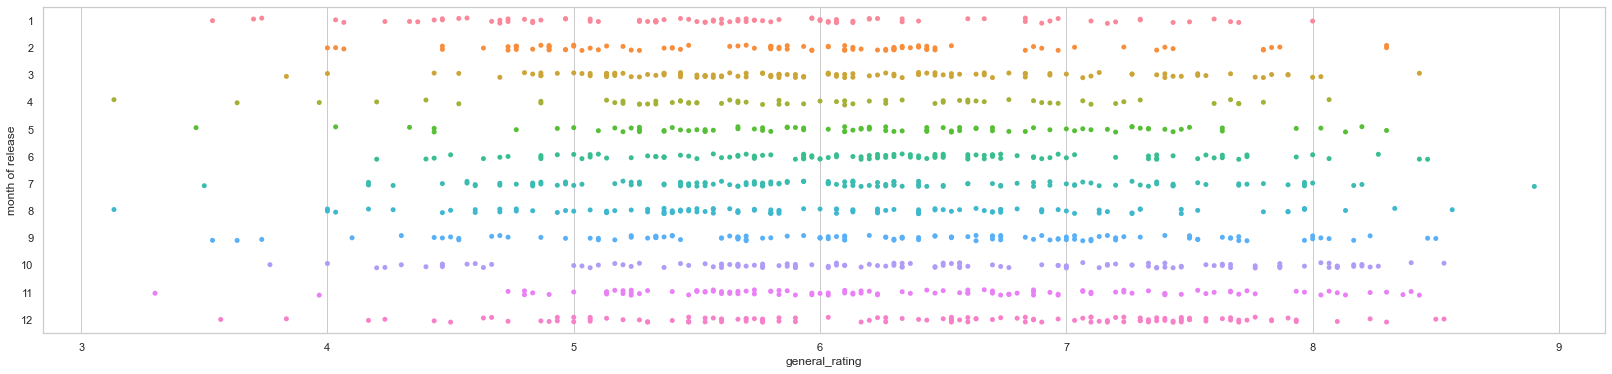

In [34]:
f = plt.figure(figsize=(28, 6))
sb.stripplot(x ="general_rating", y = "month of release", data = exploringData, orient = "h")

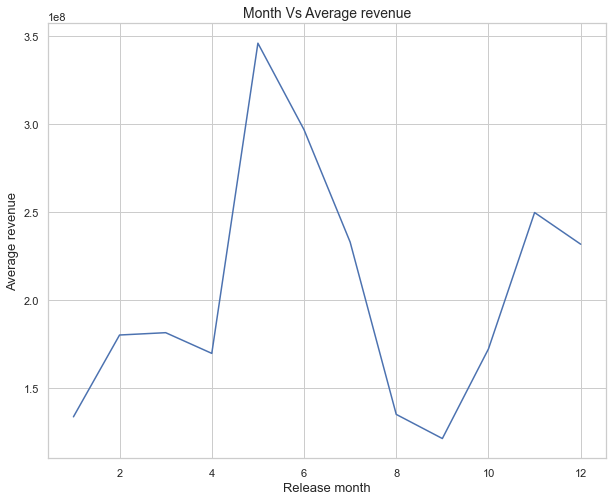

In [35]:
exploringData.groupby('month of release')['real_revenue'].mean().plot()

#setup the title and labels of the figure.
plt.title("Month Vs Average revenue",fontsize = 14)
plt.xlabel('Release month',fontsize = 13)
plt.ylabel('Average revenue',fontsize = 13)

#setup the figure size.
sb.set(rc={'figure.figsize':(10,8)})
sb.set_style("whitegrid")

<AxesSubplot:xlabel='real_revenue', ylabel='month of release'>

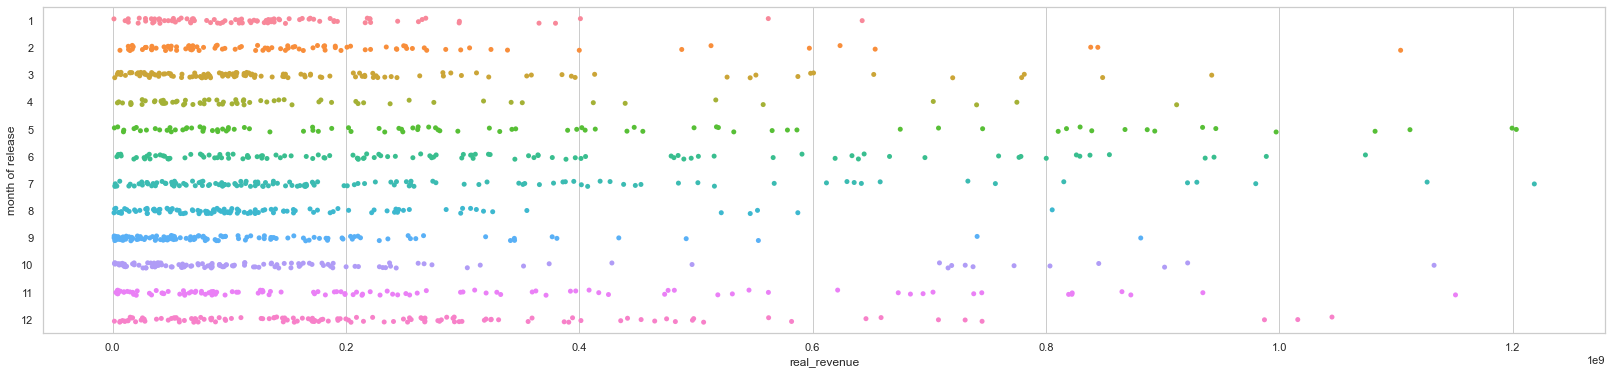

In [36]:
f = plt.figure(figsize=(28, 6))
sb.stripplot(x ="real_revenue", y = "month of release", data = exploringData, orient = "h")

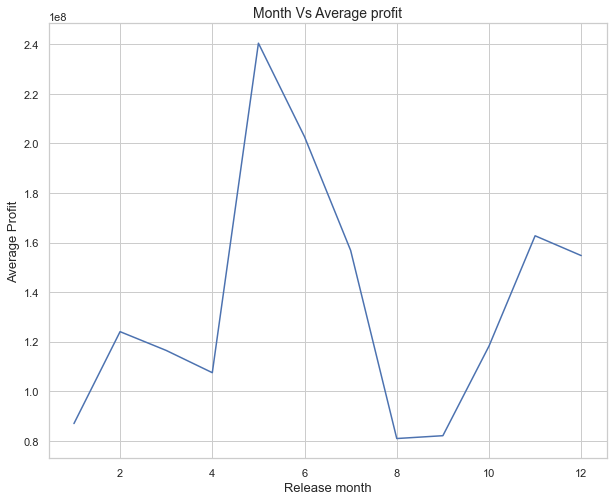

In [37]:
exploringData.groupby('month of release')['real_profit'].mean().plot()

#setup the title and labels of the figure.
plt.title("Month Vs Average profit",fontsize = 14)
plt.xlabel('Release month',fontsize = 13)
plt.ylabel('Average Profit',fontsize = 13)

#setup the figure size.
sb.set(rc={'figure.figsize':(10,8)})
sb.set_style("whitegrid")

<AxesSubplot:xlabel='real_profit', ylabel='month of release'>

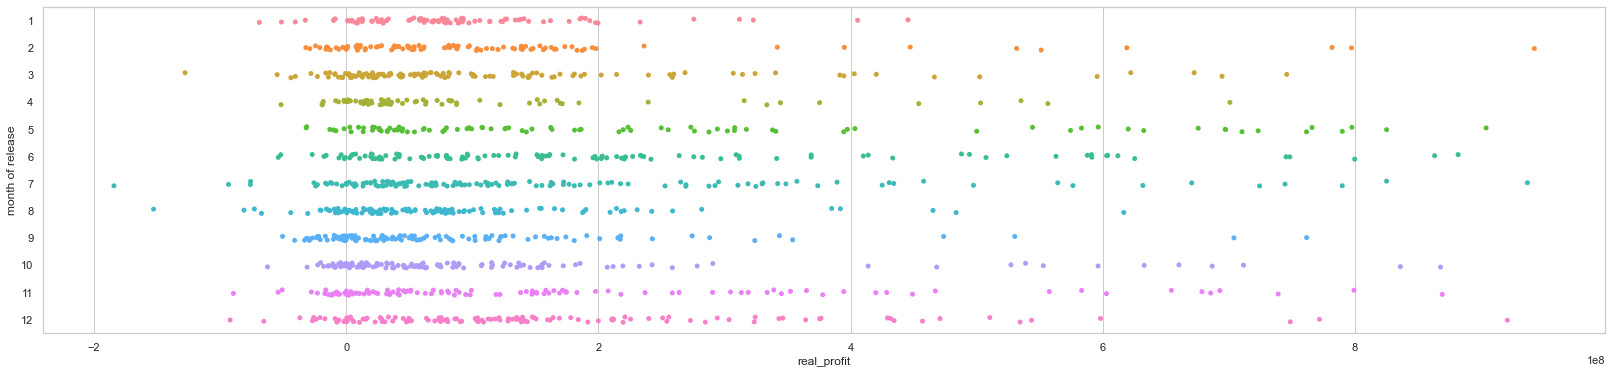

In [38]:
f = plt.figure(figsize=(28, 6))
sb.stripplot(x ="real_profit", y = "month of release", data = exploringData, orient = "h")

**Comments on Month as a predictor for movie performance**

While the scatter plots do not tell us much about the relationship between profit, ratings and the month of release, we can still observe some interesting facts.

1. Profits, revenue and ratings enjoy an upward trend from the month of January to June.

2. Profits, revenue and ratings have a downward trend from roughly June to August.

---
## iii) Genre

**GENRE VS PROFITS**

In [39]:
genre_list = []
for i in range(len(exploringData["Genre"])):
    genre_list.append(exploringData["Genre"][i].split(", "))
    
diff_genre_types= set()
for i in range(len(genre_list)):
    for j in range(len(genre_list[i])):
         diff_genre_types.add(genre_list[i][j])
            
genre_list = list(diff_genre_types)

print(genre_list)


genre_data = exploringData.copy()

for i in diff_genre_types:
    genre_data[i] = False

for i in range(len(genre_data)):
    for j in genre_list:
        if j in genre_data["Genre"][i].split(", "):
            genre_data[j][i] = 1

['Horror', 'Sport', 'Musical', 'Sci-Fi', 'History', 'Adventure', 'Animation', 'War', 'Music', 'Family', 'Crime', 'Romance', 'Western', 'Biography', 'Fantasy', 'Action', 'Thriller', 'Comedy', 'Drama', 'Documentary', 'Mystery']


<ipython-input-39-1acb10937eb7>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_data[j][i] = 1


[(566, 'Drama'), (492, 'Action'), (484, 'Thriller')]
[(4, 'Documentary'), (17, 'Western'), (28, 'Musical')]


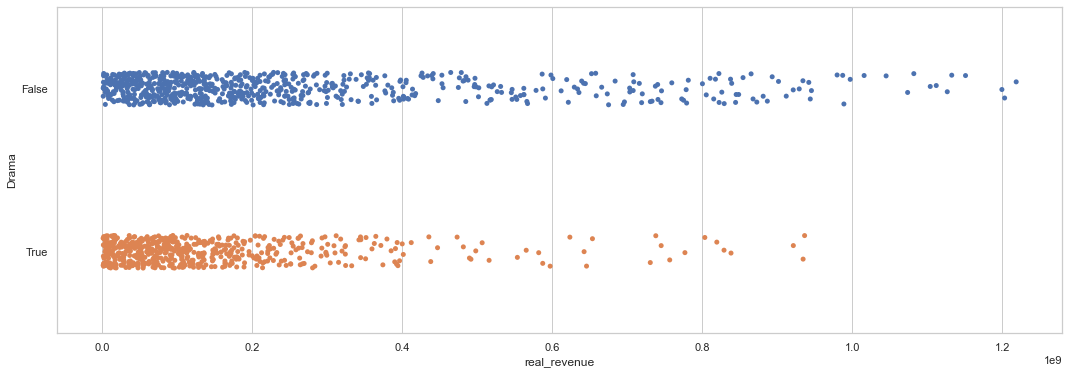

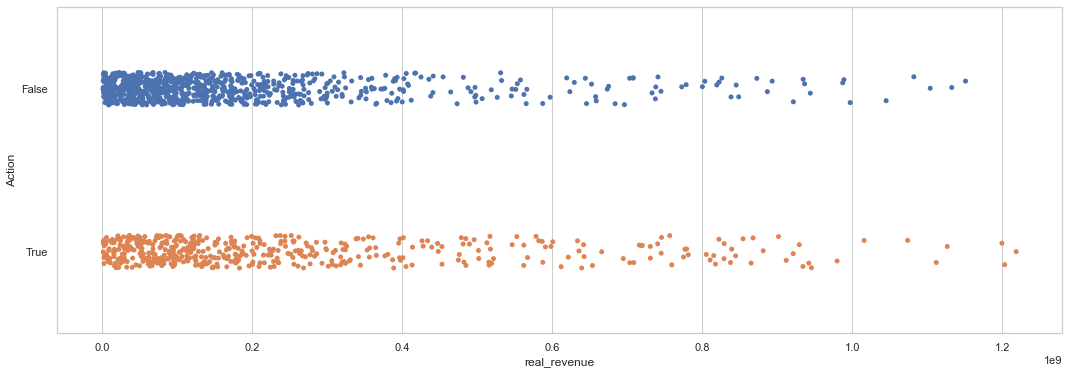

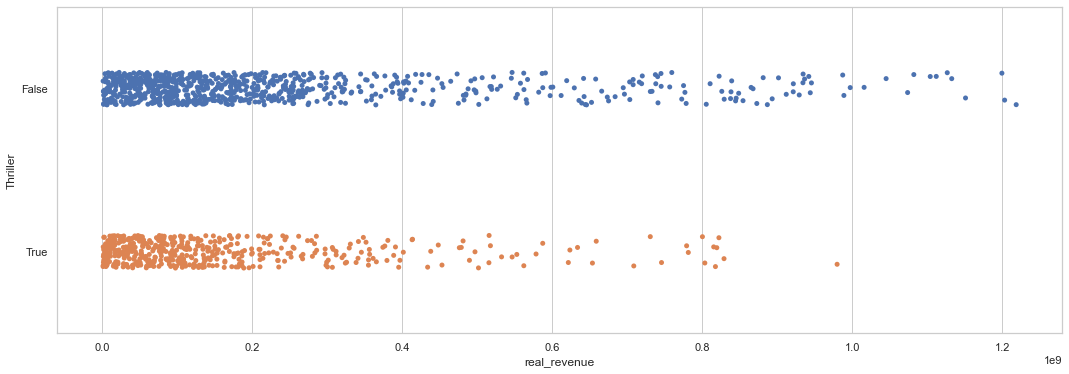

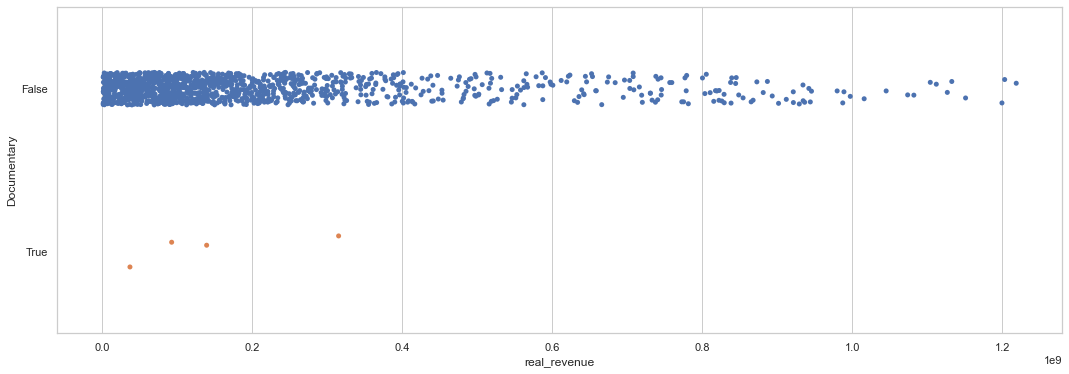

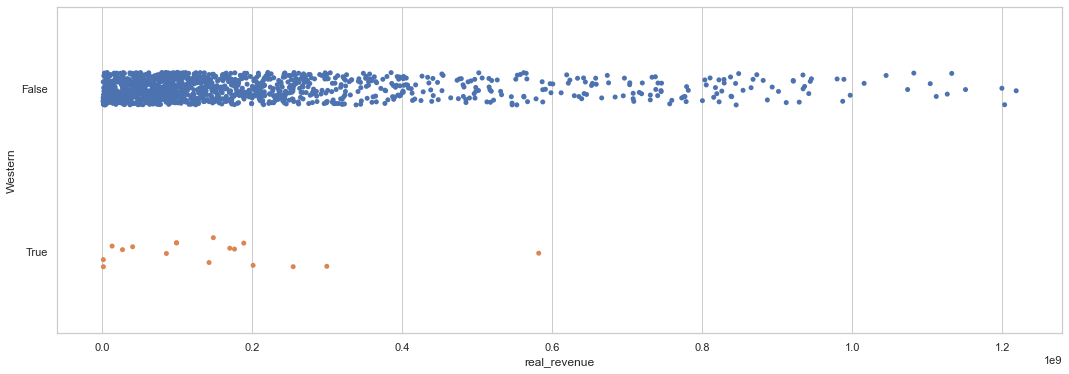

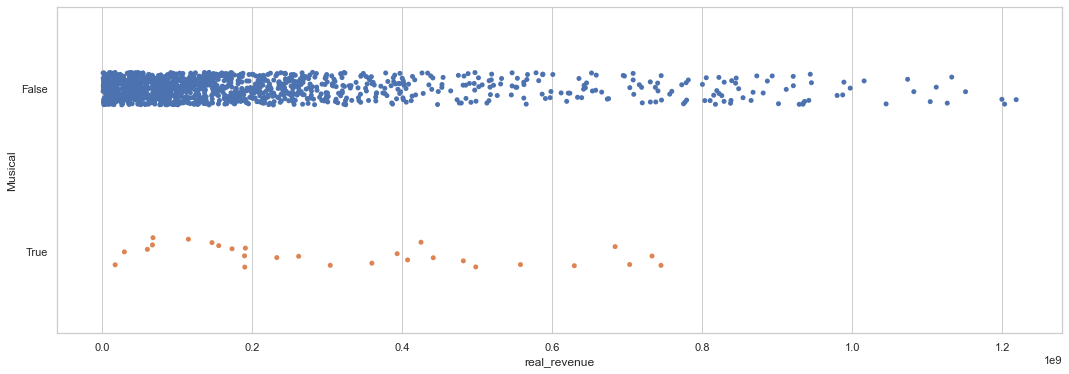

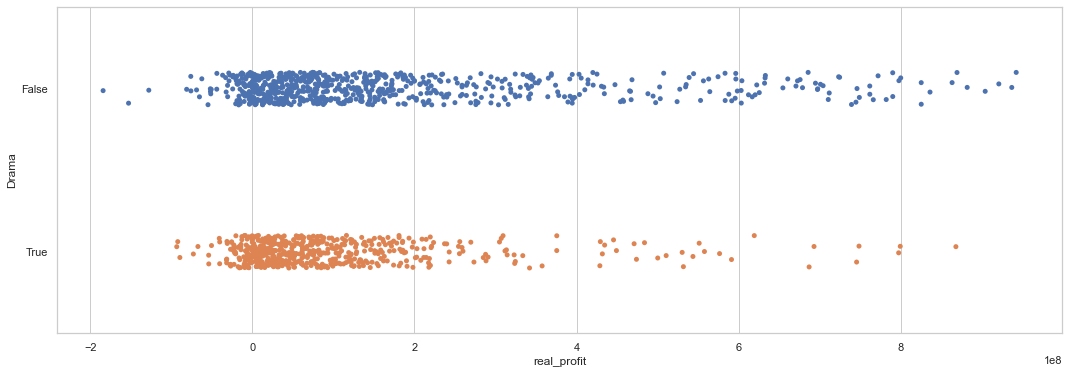

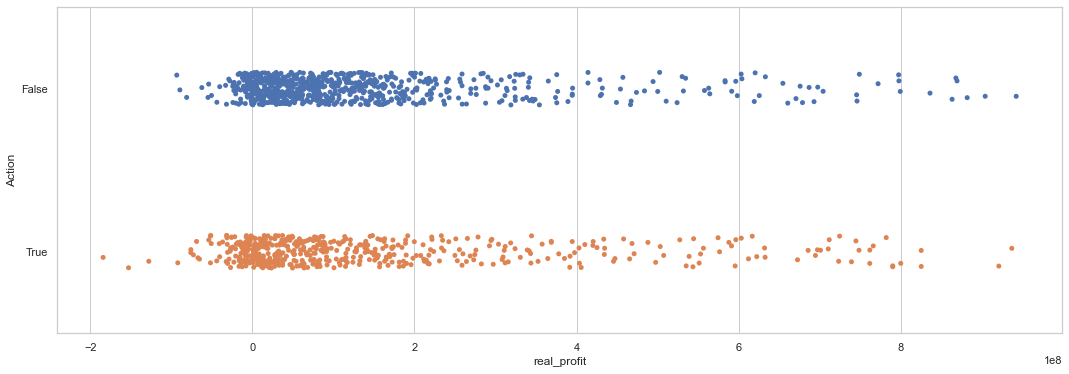

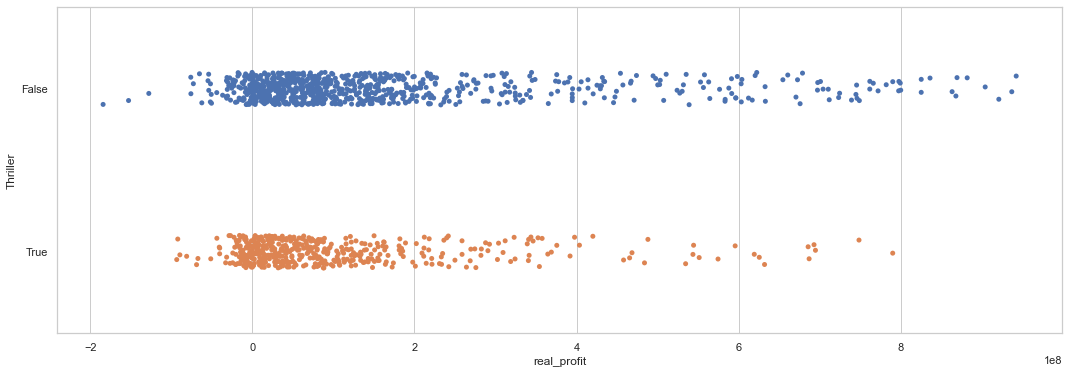

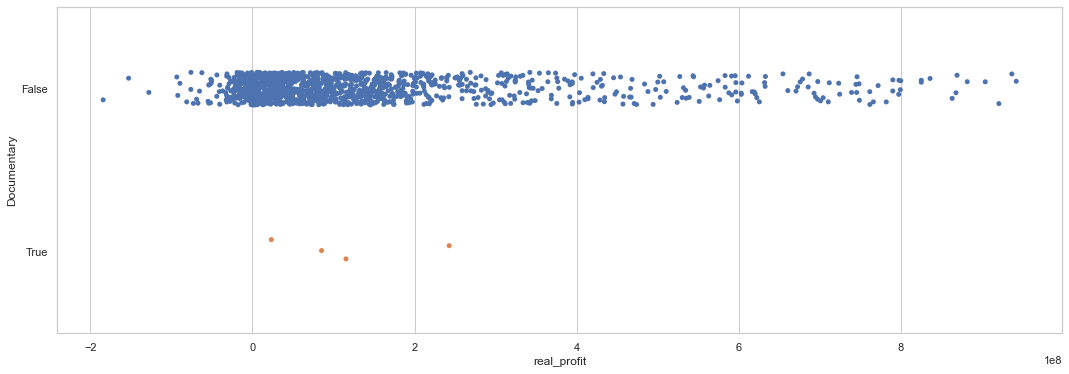

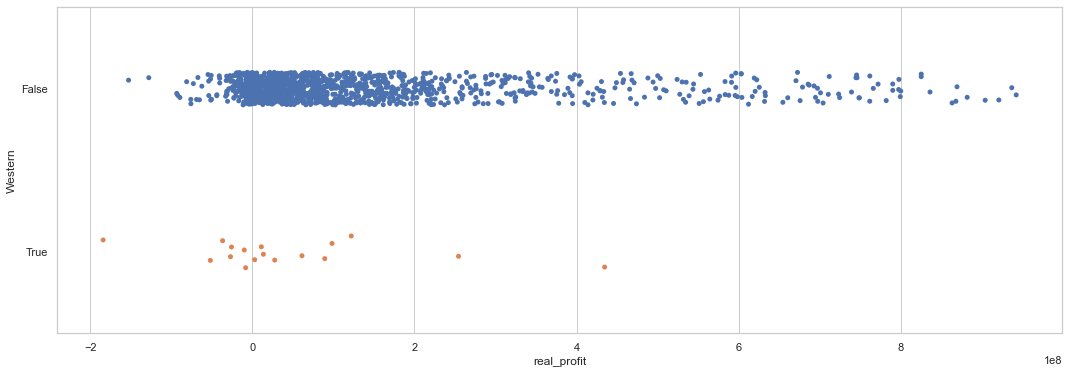

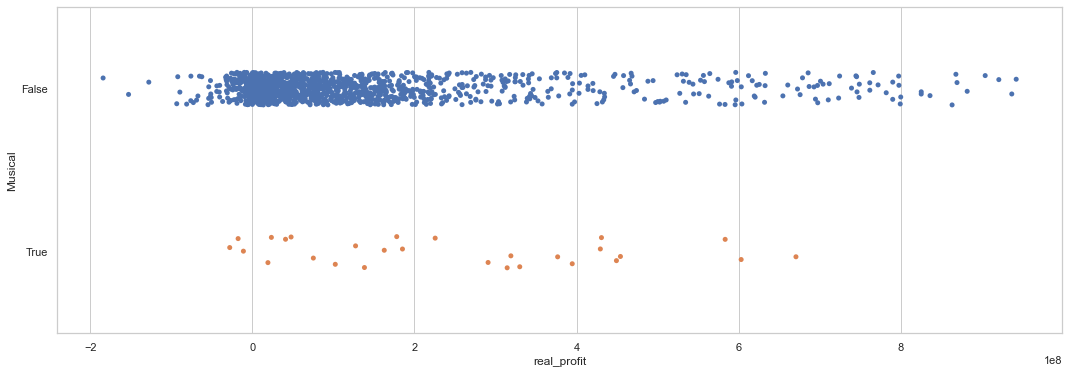

In [40]:
genre_list2 = [genre_data[i].value_counts()[1] for i in genre_list]
print(sorted([(x,genre_list[i]) for (i,x) in enumerate(genre_list2)], reverse=True )[:3] )
print(sorted([(x,genre_list[i]) for (i,x) in enumerate(genre_list2)])[:3] )


most_popular_genres = ["Drama", "Action", "Thriller"]
most_unpopular_genres = ["Documentary",'Western','Musical'  ]
for i in most_popular_genres:
    f = plt.figure(figsize=(18, 6))
    sb.stripplot(x ="real_revenue", y = i, data = genre_data, orient = "h")

for i in most_unpopular_genres:
    f = plt.figure(figsize=(18, 6))
    sb.stripplot(x ="real_revenue", y = i, data = genre_data, orient = "h")
    

for i in most_popular_genres:
    f = plt.figure(figsize=(18, 6))
    sb.stripplot(x ="real_profit", y = i, data = genre_data, orient = "h")

for i in most_unpopular_genres:
    f = plt.figure(figsize=(18, 6))
    sb.stripplot(x ="real_profit", y = i, data = genre_data, orient = "h")

**Comments on Genre v Real Profits / Real revenue**

From the above stripplots, we can see that there is no substatial separation of profits and revenue between when a given genre is **True**, indicating that a movie is of that particular genre, and when it is **False**.

Based on that, it seems that the genre of a movie alone does **not** serve as a good indicator of what the real profits and revenue of the movie would be.

**GENRE VS RATING**

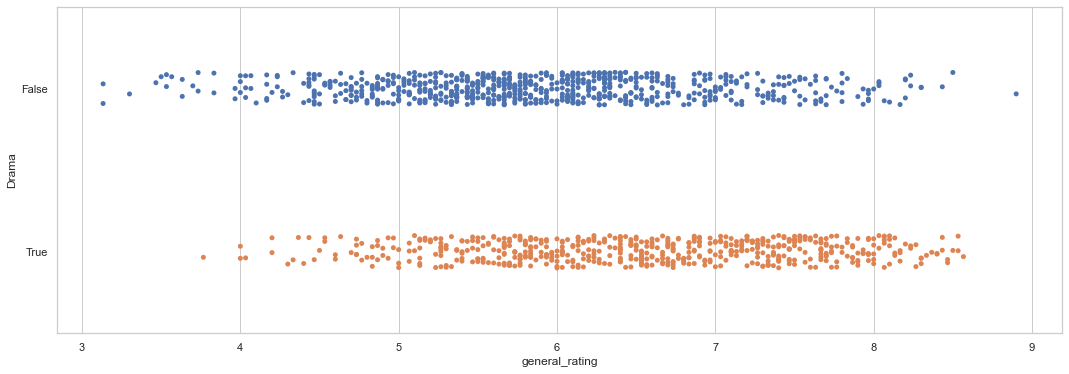

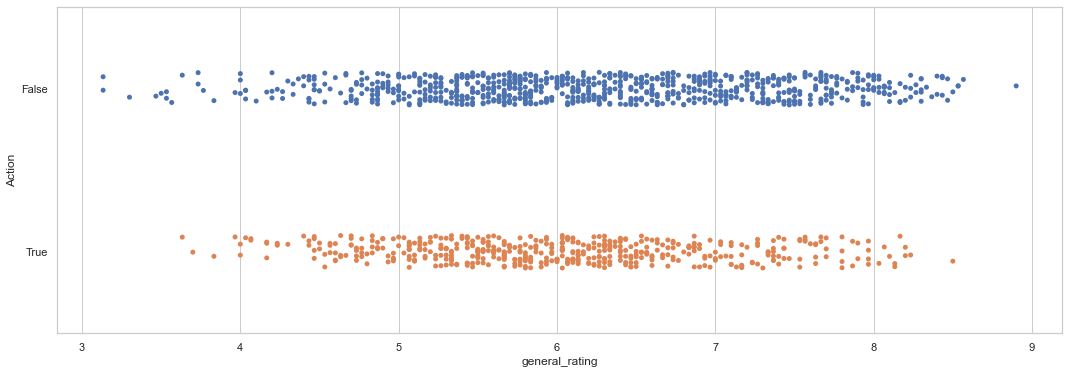

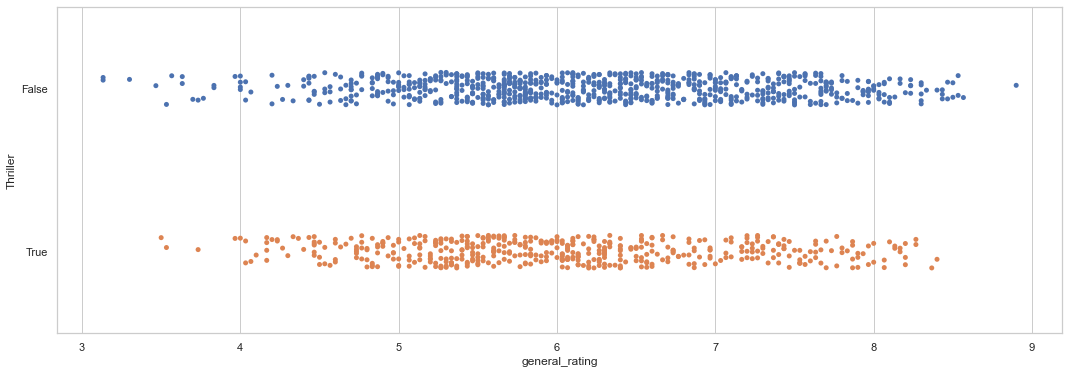

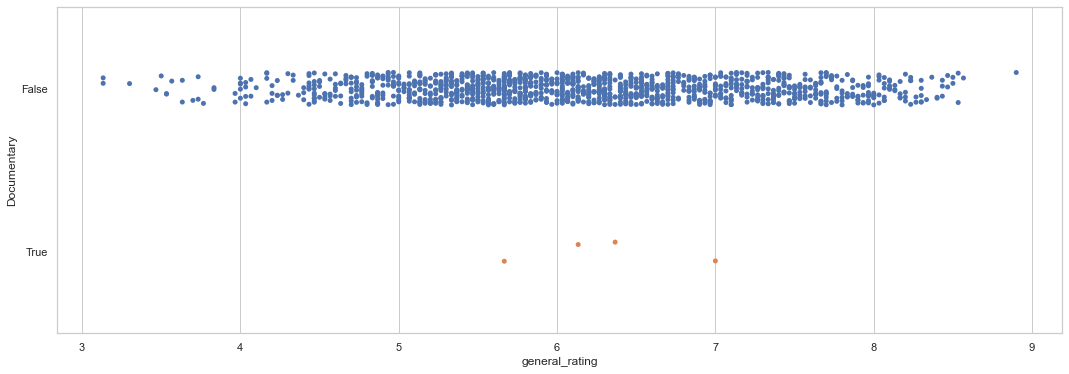

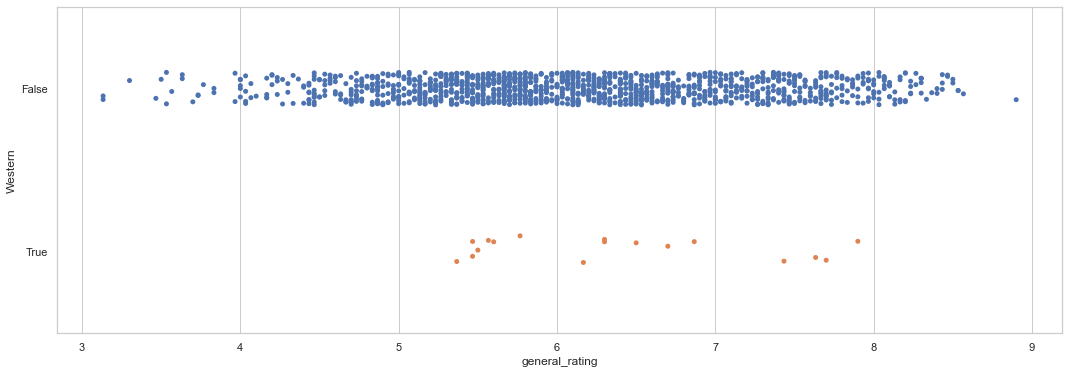

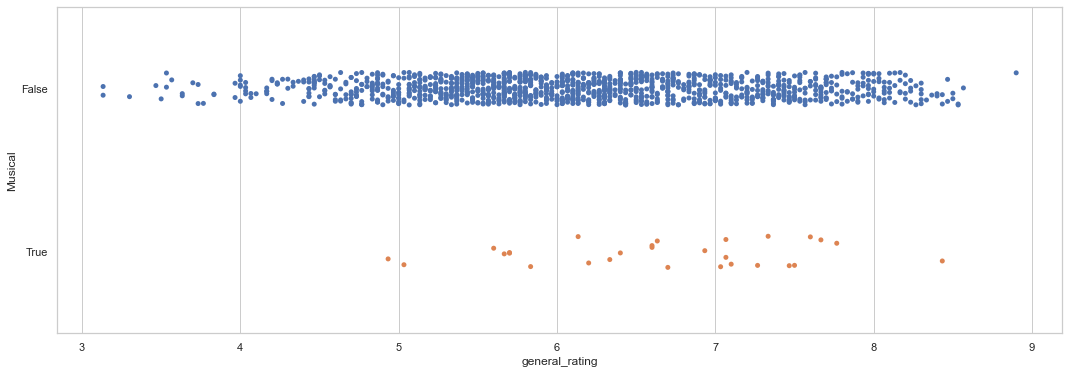

In [41]:
for i in most_popular_genres:
    f = plt.figure(figsize=(18, 6))
    sb.stripplot(x ="general_rating", y = i, data = genre_data, orient = "h")

for i in most_unpopular_genres:
    f = plt.figure(figsize=(18, 6))
    sb.stripplot(x ="general_rating", y = i, data = genre_data, orient = "h")

**Comments on Genre v General Rating**

Similar to ther results of Genre v Real Profits, there is no substantial separation of the ratings between when a given genre is **True**, as compared to movies with that are not of the same genre (**False**).

Based on that, it seems that the genre of a movie also do **not** serve as a good indicator of how well a movie will perform based on profits.

--

--

---
## iv) Key points and insights from exploratory analysis


In [42]:
yearly_runtime = pd.DataFrame(exploringData.groupby('Year')['runtime'].mean())
percentage_change = (yearly_runtime.values[19][0] - yearly_runtime.values[0][0]) / yearly_runtime.values[0][0]
print("Percentage Change in Runtime: " + str((percentage_change*100).round(2))+ "%")

Percentage Change in Runtime: 3.86%


**RUN-TIME**

Runtime length have increased by 3.86% from 2000 to 2018, and has held fairly steady. 

In [43]:
# % change for profits: 
yearly_profit = pd.DataFrame(exploringData.groupby('Year')['profit'].mean())
percentage_change = (yearly_profit.values[19][0] - yearly_profit.values[0][0]) / yearly_profit.values[0][0]
print("Percentage Change in Unadjusted Profit: " + str((percentage_change*100).round(2))+ "%")

yearly_profit = pd.DataFrame(exploringData.groupby('Year')['real_profit'].mean())
percentage_change = (yearly_profit.values[19][0] - yearly_profit.values[0][0]) / yearly_profit.values[0][0]
print("Percentage Change in Adjusted Profit: " + str((percentage_change*100).round(2))+ "%")

Percentage Change in Unadjusted Profit: 8.04%
Percentage Change in Adjusted Profit: -28.32%


In [44]:
# % change for revenue: 
yearly_revenue = pd.DataFrame(exploringData.groupby('Year')['revenue'].mean())
percentage_change = (yearly_revenue.values[19][0] - yearly_revenue.values[0][0]) / yearly_revenue.values[0][0]
print("Percentage Change in Unadjusted Revenue: " + str((percentage_change*100).round(2))+ "%")

yearly_revenue = pd.DataFrame(exploringData.groupby('Year')['real_revenue'].mean())
percentage_change = (yearly_revenue.values[19][0] - yearly_revenue.values[0][0]) / yearly_revenue.values[0][0]
print("Percentage Change in Adjusted Revenue: " + str((percentage_change*100).round(2))+ "%")

Percentage Change in Unadjusted Revenue: 6.78%
Percentage Change in Adjusted Revenue: -29.16%


**Revenue / Profit by year**


We can see that for movie profits and revenue seem to be **increasing** from 2000 to 2018.. However, after accounting for inflation, both of them have **decreased**.

**Revenue / Profit by month**

1. Profits, revenue and ratings have an upward trend from January to June.

2. Profits, revenue and profits have a downward trend from July to August.

**Genres**

"Drama", "Action", "Thriller" ARE THE MOST POPULAR genres in general, while "Documentary",'Western','Musical' are the least popular.

**Predictors and responses**

Revenue and Budget have a strong positive correlation.

Profit and Budget have a moderate positive correlation.

Ratings and run-time have a moderate positive correlation. 

We should use these pairs of predictors and response variables in our machine learning.